## Visulisierung der Daten eines Zeitfenster der Datenerfassung
In diesem Notebook werden einzelne Bildaufnahmen mit den assoziierten Sensordaten dargestellt.
Zudem werden die 3-Achsen Beschleunigungssensormesswert und die Lagewinkel Nick-Roll-Gier geplottet mit den berechneten Merkmalen Mittelwerte, Varianz und Standardabweichung der Messwerte.

In [86]:
# Import von Bibliotheken
import os
import pandas
import numpy as np

In [87]:
import cv2
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import ImageGrid
from ipyleaflet import *

In [88]:
# Lesen der Merkmale
featuresDf = pandas.read_csv("../daten/merkmale.csv")
featuresDf.describe()

,Zeitstempel in Unixzeit,Breitengrad,Laengengrad,Geschwindigkeit in km/h,Hoehe in m ueber WGS 84,Anzahl der Messwerte,Start des Zeitfensters in ns seit Start der JVM,Start der Messwerterfassung in ns seit Start der JVM,Start der Belichtung in ns seit Start der JVM,Belichtungszeit in ns,...,Varianz X-Achse Beschleunigung in m/s^2,Varianz Y-Achse Beschleunigung in m/s^2,Varianz Z-Achse Beschleunigung in m/s^2,Varianz Nick in rad,Varianz Roll in rad,Standardabweichung X-Achse Beschleunigung in m/s^2,Standardabweichung Y-Achse Beschleunigung in m/s^2,Standardabweichung Z-Achse Beschleunigung in m/s^2,Standardabweichung Nick in rad,Standardabweichung Roll in rad
count,1.935000e+03,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1.935000e+03,1.935000e+03,1.935000e+03,1.935000e+03,...,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000
mean,1.521815e+12,53.611756,10.141385,15.431479,70.983613,19.335401,1.232928e+14,1.232927e+14,1.232928e+14,1.717044e+07,...,5.090925,40.109086,47.298581,0.453278,0.755017,1.843783,4.890581,5.664694,0.604631,0.617375
std,1.711999e+05,0.001963,0.004292,2.578698,2.540434,0.574053,1.712002e+11,1.712002e+11,1.712005e+11,5.915285e+06,...,9.928539,84.530317,74.631600,0.415298,1.384871,1.300870,4.024882,3.900985,0.296218,0.611603
min,1.521815e+12,53.608086,10.136243,6.012000,64.299440,14.000000,1.229923e+14,1.229923e+14,1.229924e+14,1.000184e+07,...,0.051570,0.293240,0.390830,0.004730,0.001030,0.227090,0.541520,0.625160,0.068770,0.032090
25%,1.521815e+12,53.610050,10.137212,14.256000,69.145140,19.000000,1.231447e+14,1.231447e+14,1.231448e+14,1.000184e+07,...,0.955515,5.312705,8.138980,0.129180,0.027425,0.977505,2.304930,2.852890,0.359415,0.165605
50%,1.521815e+12,53.612152,10.140454,15.768001,71.069275,19.000000,1.232957e+14,1.232956e+14,1.232957e+14,2.000368e+07,...,2.177540,13.362630,20.536700,0.327060,0.113760,1.475650,3.655490,4.531740,0.571890,0.337280
75%,1.521815e+12,53.613777,10.145028,17.208002,72.942380,20.000000,1.234378e+14,1.234377e+14,1.234378e+14,2.000368e+07,...,5.343015,33.826275,52.282975,0.663675,0.834570,2.311500,5.816035,7.230695,0.814660,0.913545
max,1.521815e+12,53.613907,10.149695,20.268002,77.023680,22.000000,1.235899e+14,1.235898e+14,1.235899e+14,2.999632e+07,...,190.706400,1037.005440,998.218210,2.811090,12.292420,13.809650,32.202570,31.594590,1.676630,3.506050


In [89]:
featuresDf.columns

Index(['Zeitstempel in Unixzeit', 'Breitengrad', 'Laengengrad',
       'Geschwindigkeit in km/h', 'Hoehe in m ueber WGS 84',
       'X-Achse Beschleunigungswerte in m/s^2',
       'Y-Achse Beschleunigungswerte in m/s^2',
       'Z-Achse Beschleunigungswerte in m/s^2', 'Gier Messwerte in rad',
       'Nick Messwerte in rad', 'Roll Messwerte in rad',
       'Zeitstempel der Messwerte in ns', 'Anzahl der Messwerte',
       'Start des Zeitfensters in ns seit Start der JVM',
       'Start der Messwerterfassung in ns seit Start der JVM',
       'Start der Belichtung in ns seit Start der JVM',
       'Belichtungszeit in ns',
       'Letzter Zeitstempel der Messwerterfassung in ns seit Start der JVM',
       'Stopp der Messwerterfassung in Unixzeit',
       'Mittelwert X-Achse Beschleunigung in m/s^2',
       'Mittelwert Y-Achse Beschleunigung in m/s^2',
       'Mittelwert Z-Achse Beschleunigung in m/s^2', 'Mittelwert Nick in rad',
       'Mittelwert Roll in rad', 'Gier-Aenderung in rad',
    

In [90]:
%%time
# Lade Messwerte 
accXDf = pandas.read_csv("../daten/x-Achse-Beschleunigungswerte.csv")
accXDf.drop(['index'],axis=1 ,inplace=True)
accYDf = pandas.read_csv("../daten/y-Achse-Beschleunigungswerte.csv")
accYDf.drop(['index'],axis=1 ,inplace=True)
accZDf = pandas.read_csv("../daten/z-Achse-Beschleunigungswerte.csv")
accZDf.drop(['index'],axis=1 ,inplace=True)
pitchDf = pandas.read_csv("../daten/nick-Messwerte.csv")
pitchDf.drop(['index'],axis=1 ,inplace=True)
rollDf = pandas.read_csv("../daten/roll-Messwerte.csv")
rollDf.drop(['index'],axis=1 ,inplace=True)
azimuthDf = pandas.read_csv("../daten/azimuth-Messwerte.csv")
azimuthDf.drop(['index'],axis=1 ,inplace=True)
sensorTimestampsDf = pandas.read_csv("../daten/sensorevent-Zeitstempel.csv")
sensorTimestampsDf.drop(['index'],axis=1 ,inplace=True)

Wall time: 176 ms


In [91]:
# Index von welchem die Messwerte dargestellt werden sollen
row = 420
# Der erste und letzte Zeitstempel der Messwerterfassung
sensorTimestamps =  sensorTimestampsDf.iloc[row] / 1000000
timestampsMinMax = [sensorTimestampsDf.iloc[row,0]/ 1000000,sensorTimestampsDf.iloc[[row]].dropna(axis=1, how='any').iloc[0,-1]/ 1000000]
# Belichtungszeit vom Start bis zum Ende
startExposureTime = featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row]-featuresDf['Start des Zeitfensters in ns seit Start der JVM'].iloc[row]
exposureTime = [startExposureTime/1000000,startExposureTime/1000000 + featuresDf['Belichtungszeit in ns'].iloc[row]/1000000]

In [92]:
df = accXDf.iloc[[row]]
# Spalten mit NaN werten werden entfernt
df.dropna(axis=1, how='any')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
420,-1.559,-1.40038,-2.8977,2.11022,4.6762,2.0555,0.03556,-0.61506,-3.61785,-2.46518,0.41828,-0.82985,-1.62917,-0.75165,0.33344,1.64587,1.57725,0.43442,1.51214,-0.67495


In [93]:
sensorTimestampsDf.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,4426297.0,7254527.0,11344735.0,15185047.0,21288902.0,23482756.0,27200568.0,31197131.0,35663120.0,38841975.0,...,52763589.0,54647860.0,59010152.0,62394683.0,67582860.0,70820881.0,74384839.0,NaN,NaN,NaN
1,5925016.0,7188610.0,11660641.0,16075693.0,22232308.0,25927985.0,28724235.0,30761474.0,43462516.0,43618141.0,...,51629183.0,60206474.0,60327933.0,62772047.0,66692204.0,71008714.0,74963245.0,NaN,NaN,NaN


In [94]:
timestampsMinMax

[0.893619, 76.530911]

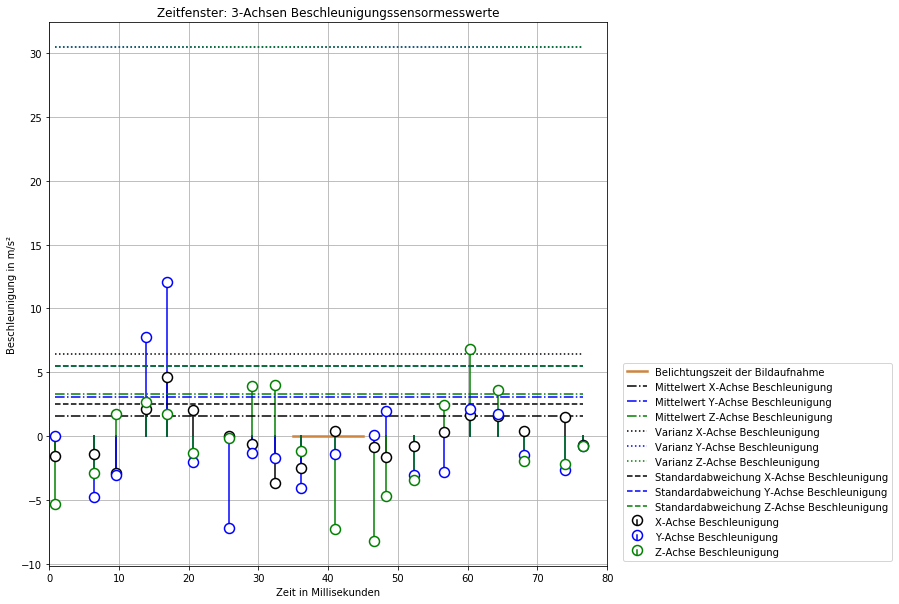

In [102]:
# PLot 3-Achsen Beschleunigungssensormesswerte aufgenommen innerhalb eines Zeitfenster
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111)
ax.plot(exposureTime,[0,0], color='peru', linewidth=2.5, label='Belichtungszeit der Bildaufnahme')
# Beschleunigungsmesswerte
# X-Achse
(markers, stemlines, baseline) = ax.stem(sensorTimestamps.dropna(), accXDf.iloc[row].dropna(), 'k-', basefmt='None', markerfmt='wo', label='X-Achse Beschleunigung')
plt.setp(stemlines, linestyle="-", color="k", linewidth=1.5)
plt.setp(markers, markeredgecolor='k', markersize=10, markeredgewidth=1.5, zorder=3)
# Y-Achse
(markers, stemlines, baseline) = ax.stem(sensorTimestamps.dropna(),accYDf.iloc[row].dropna(), 'b-', basefmt='None', markerfmt='wo', label='Y-Achse Beschleunigung')
plt.setp(stemlines, linestyle="-", color="b", linewidth=1.5)
plt.setp(markers, markeredgecolor='b', markersize=10, markeredgewidth=1.5, zorder=3)
# Z-Achse
(markers, stemlines, baseline) = ax.stem(sensorTimestamps.dropna(), accZDf.iloc[row].dropna(), 'g-', basefmt='None', markerfmt='wo', label='Z-Achse Beschleunigung')
plt.setp(stemlines, linestyle="-", color="g", linewidth=1.5)
plt.setp(markers, markeredgecolor='g', markersize=10, markeredgewidth=1.5, zorder=3)
# Mittelwerte der 3-Achsen Beschleunigungmesswerte
ax.plot(timestampsMinMax,[featuresDf['Mittelwert X-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Mittelwert X-Achse Beschleunigung in m/s^2'].iloc[row]], color='black', linestyle='-.', label='Mittelwert X-Achse Beschleunigung')
ax.plot(timestampsMinMax,[featuresDf['Mittelwert Y-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Mittelwert Y-Achse Beschleunigung in m/s^2'].iloc[row]], color='blue', linestyle='-.', label='Mittelwert Y-Achse Beschleunigung')
ax.plot(timestampsMinMax,[featuresDf['Mittelwert Z-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Mittelwert Z-Achse Beschleunigung in m/s^2'].iloc[row]], color='green', linestyle='-.', label='Mittelwert Z-Achse Beschleunigung')
# Varianz der 3-Achsen Beschleunigungmesswerte
ax.plot(timestampsMinMax,[featuresDf['Varianz X-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Varianz X-Achse Beschleunigung in m/s^2'].iloc[row]], color='black', linestyle=':', label='Varianz X-Achse Beschleunigung')
ax.plot(timestampsMinMax,[featuresDf['Varianz Y-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Varianz Y-Achse Beschleunigung in m/s^2'].iloc[row]], color='blue', linestyle=':', label='Varianz Y-Achse Beschleunigung')
ax.plot(timestampsMinMax,[featuresDf['Varianz Z-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Varianz Z-Achse Beschleunigung in m/s^2'].iloc[row]], color='green', linestyle=':', label='Varianz Z-Achse Beschleunigung')
# Standardabweichung 3-Achsen Beschleunigungsmesswerte
ax.plot(timestampsMinMax,[featuresDf['Standardabweichung X-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Standardabweichung X-Achse Beschleunigung in m/s^2'].iloc[row]], color='black', linestyle='--', label='Standardabweichung X-Achse Beschleunigung')
ax.plot(timestampsMinMax,[featuresDf['Standardabweichung Y-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Standardabweichung Y-Achse Beschleunigung in m/s^2'].iloc[row]], color='blue',linestyle='--', label='Standardabweichung Y-Achse Beschleunigung')
ax.plot(timestampsMinMax,[featuresDf['Standardabweichung Z-Achse Beschleunigung in m/s^2'].iloc[row],featuresDf['Standardabweichung Z-Achse Beschleunigung in m/s^2'].iloc[row]], color='green', linestyle='--', label='Standardabweichung Z-Achse Beschleunigung')
leg = plt.legend(loc='lower right', framealpha=0.8, bbox_to_anchor=(1.52, 0.0001))
plt.title('Zeitfenster: 3-Achsen Beschleunigungssensormesswerte')
plt.xlabel('Zeit in Millisekunden')
plt.ylabel('Beschleunigung in m/s²')
plt.xlim(0,80)
plt.grid()

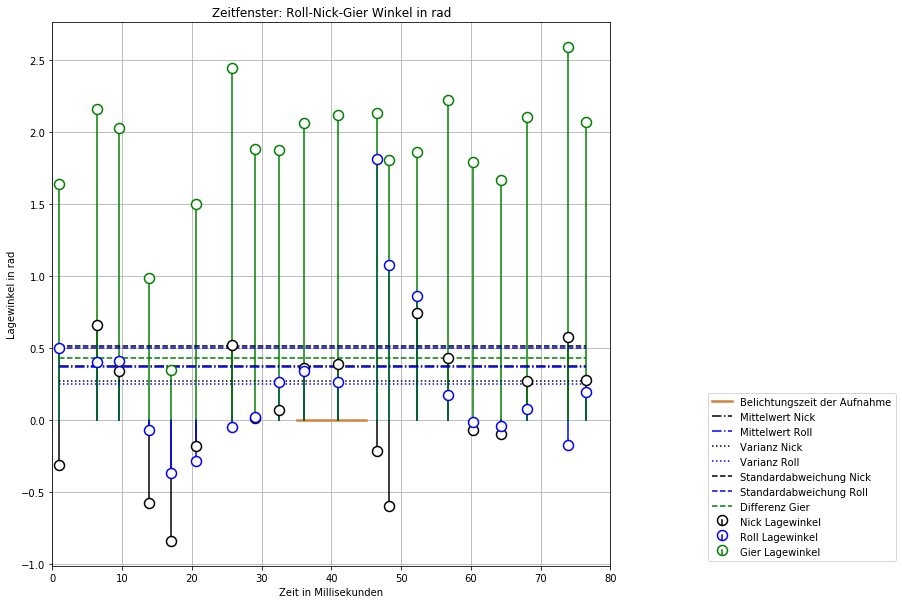

In [111]:
# Plot Nick-Roll-Gier Winkel in Rad zu einem Zeitfenster
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111)
ax.plot(exposureTime,[0,0],color='peru', linewidth=2.5, label='Belichtungszeit der Aufnahme')
# Nick Winkel Stem Plot
(markers, stemlines, baseline) = ax.stem(sensorTimestamps.dropna(), pitchDf.iloc[row].dropna(), 'k-', basefmt='None', markerfmt='wo', label='Nick Lagewinkel')
plt.setp(stemlines, linestyle='-', color='k', linewidth=1.5)
plt.setp(markers, markeredgecolor='k', markersize=10, markeredgewidth=1.5, zorder=3)
# Roll Winkel Stem Plot
(markers, stemlines, baseline) = ax.stem(sensorTimestamps.dropna(), rollDf.iloc[row].dropna(), 'b-', basefmt='None', markerfmt='wo', label='Roll Lagewinkel')
plt.setp(stemlines, linestyle="-", color='b', linewidth=1.5)
plt.setp(markers, markeredgecolor='b', markersize=10, markeredgewidth=1.5, zorder=3)
# Gier Winkel Stem Plot
(markers, stemlines, baseline) = ax.stem(sensorTimestamps.dropna(), azimuthDf.iloc[row].dropna(), 'g-', basefmt='None', markerfmt='wo', label='Gier Lagewinkel')
plt.setp(stemlines, linestyle="-", color='g', linewidth=1.5)
plt.setp(markers, markeredgecolor='g', markersize=10, markeredgewidth=1.5, zorder=3)
# Berechnete Merkmale aus den Winkeln 
# Mittelwert der Winkel
ax.plot(timestampsMinMax,[featuresDf['Mittelwert Nick in rad'].iloc[row],featuresDf['Mittelwert Nick in rad'].iloc[row]], color='black', linestyle='-.', label='Mittelwert Nick')
ax.plot(timestampsMinMax,[featuresDf['Mittelwert Roll in rad'].iloc[row],featuresDf['Mittelwert Roll in rad'].iloc[row]], color='blue', linestyle='-.', label='Mittelwert Roll')
# Varianz der Winkel
ax.plot(timestampsMinMax,[featuresDf['Varianz Nick in rad'].iloc[row],featuresDf['Varianz Nick in rad'].iloc[row]], color='black', linestyle=':', label='Varianz Nick')
ax.plot(timestampsMinMax,[featuresDf['Varianz Roll in rad'].iloc[row],featuresDf['Varianz Roll in rad'].iloc[row]], color='blue', linestyle=':', label='Varianz Roll')
# Standardabweichung der Winkel
ax.plot(timestampsMinMax,[featuresDf['Standardabweichung Nick in rad'].iloc[row],featuresDf['Standardabweichung Nick in rad'].iloc[row]], color='black', linestyle='--', label='Standardabweichung Nick')
ax.plot(timestampsMinMax,[featuresDf['Standardabweichung Roll in rad'].iloc[row],featuresDf['Standardabweichung Roll in rad'].iloc[row]], color='blue', linestyle='--', label='Standardabweichung Roll')
# Gier Änderng in rad
ax.plot(timestampsMinMax,[featuresDf['Gier-Aenderung in rad'].iloc[row],featuresDf['Gier-Aenderung in rad'].iloc[row]], color='green', linestyle='--', label='Differenz Gier')
leg = plt.legend(loc='lower right', framealpha=0.8, bbox_to_anchor=(1.52, 0.0001))
plt.title('Zeitfenster: Roll-Nick-Gier Winkel in rad')
plt.xlabel('Zeit in Millisekunden')
plt.ylabel('Lagewinkel in rad')
plt.xlim(0,80)
plt.grid()

In [113]:
# Lade Bilder in eine Liste
images = []
# Hier können die Datensätze ausgewählt werden
datasets = ['16']
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []

In [114]:
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("C:/Users/JulianAdmin/Documents/daten/" + dataset + "/zugeschnitten/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        print(filesPath)
        files = os.listdir(filesPath)
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            images.append(cv2.imread(filesPath + name, cv2.COLOR_BGR2GRAY)) # Bild wird gelesen

C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/1/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/2/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/3/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/4/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/5/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/6/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/7/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/8/


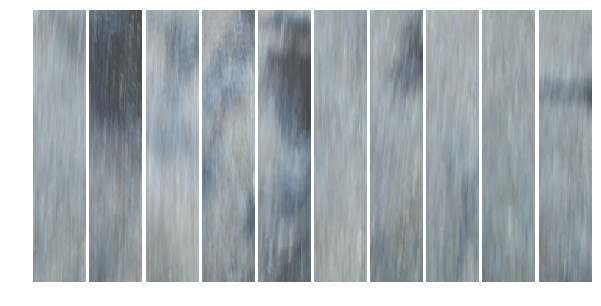

In [122]:
# Plot Beispiel Bilder
fig = plt.figure(1, figsize=(10,10))
# Anzahl der Bilder >= 10
imageToShow = 10
# Start Index des ersten Bildes
startIndex = 4450
grid = ImageGrid(fig, 111, nrows_ncols=(int(imageToShow/10), 10), axes_pad=0.05)
for i, img in enumerate(images[startIndex: startIndex + imageToShow]):
    ax = grid[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

<Figure size 720x720 with 0 Axes>

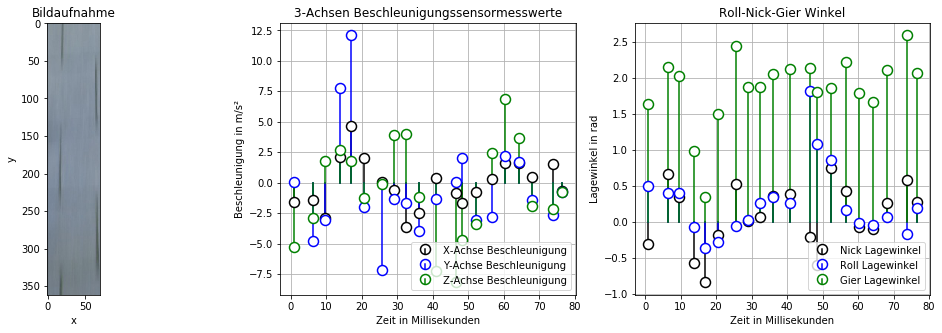

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[53.61389000000001, 10.146345], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), Marker(location=[53.61389000000001, 10.146345], opacity=0.5, options=['alt', 'clickable', 'draggable', 'keyboard', 'rise_offset', 'rise_on_hover', 'title', 'z_index_offset'])), layout=Layout(height='300px', width='1000px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=16)

In [145]:
# Mit Hilfe eines Subplots wird ein Bild mit einem Diagram der 3-Achsen Beschleunigungssensormesswerten und einem der Lagewinkel
# Roll-Nick-Gier dargestellt
plt.figure(0, figsize=(10,10))
f, axarr = plt.subplots(1, 3,figsize=(18,5))
axarr[0].imshow(images[row], cmap='gray')
axarr[0].set_title('Bildaufnahme')
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('y')
# 3-Achsen Beschleunigungssensormesswerte
# X-Achse
(markers, stemlines, baseline) = axarr[1].stem(sensorTimestamps.dropna(), accXDf.iloc[row].dropna(), 'k-', basefmt='None', markerfmt='wo', label='X-Achse Beschleunigung')
plt.setp(stemlines, linestyle='-', color='k', linewidth=1.5)
plt.setp(markers, markeredgecolor='k', markersize=10, markeredgewidth=1.5, zorder=3)
# Y-Achse
(markers, stemlines, baseline) = axarr[1].stem(sensorTimestamps.dropna(), accYDf.iloc[row].dropna(), 'b-', basefmt='None', markerfmt='wo', label='Y-Achse Beschleunigung')
plt.setp(stemlines, linestyle='-', color='b', linewidth=1.5)
plt.setp(markers, markeredgecolor='b', markersize=10, markeredgewidth=1.5, zorder=3)
# Z-Achse
(markers, stemlines, baseline) = axarr[1].stem(sensorTimestamps.dropna(), accZDf.iloc[row].dropna(), 'g-', basefmt='None', markerfmt='wo', label='Z-Achse Beschleunigung')
plt.setp(stemlines, linestyle='-', color='g', linewidth=1.5)
plt.setp(markers, markeredgecolor='g', markersize=10, markeredgewidth=1.5, zorder=3)
axarr[1].set_title('3-Achsen Beschleunigungssensormesswerte')
axarr[1].set_xlabel('Zeit in Millisekunden')
axarr[1].set_ylabel('Beschleunigung in m/s²')
axarr[1].grid(True)
axarr[1].legend(loc='lower right', framealpha=0.8)
# Lagewinkel
(markers, stemlines, baseline) = axarr[2].stem(sensorTimestamps.dropna(), pitchDf.iloc[row].dropna(), 'k-', basefmt='None', markerfmt='wo', label='Nick Lagewinkel')
plt.setp(stemlines, linestyle='-', color='k', linewidth=1.5)
plt.setp(markers, markeredgecolor='k', markersize=10, markeredgewidth=1.5, zorder=3)
(markers, stemlines, baseline) = axarr[2].stem(sensorTimestamps.dropna(), rollDf.iloc[row].dropna(), 'b-', basefmt='None', markerfmt='wo', label='Roll Lagewinkel')
plt.setp(stemlines, linestyle="-", color='b', linewidth=1.5)
plt.setp(markers, markeredgecolor='b', markersize=10, markeredgewidth=1.5, zorder=3)
(markers, stemlines, baseline) = axarr[2].stem(sensorTimestamps.dropna(), azimuthDf.iloc[row].dropna(), 'g-', basefmt='None', markerfmt='wo', label='Gier Lagewinkel')
plt.setp(stemlines, linestyle="-", color='g', linewidth=1.5)
plt.setp(markers, markeredgecolor='g', markersize=10, markeredgewidth=1.5, zorder=3)
axarr[2].set_title('Roll-Nick-Gier Winkel')
axarr[2].set_xlabel('Zeit in Millisekunden')
axarr[2].set_ylabel('Lagewinkel in rad')
axarr[2].grid(True)
axarr[2].legend(loc='lower right', framealpha=0.8)
plt.show()
# Abstand der Subplots
f.subplots_adjust(hspace=0.5)
# ipyleaflet Karte
m = Map(center=(featuresDf.Breitengrad.iloc[row],featuresDf.Laengengrad.iloc[row]),zoom=16, layout=dict(width='1000px', height='300px'))
mark = Marker( location= m.center, opacity=0.5)
m += mark
m